# Project Benson

Zach Heick, Eric Chan, Ming Tang

WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As they are a new and inclusive organization, they try to do double duty with the gala both to fill event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach. They place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to the gala. They want to use MTA subway data to help optimize the placement of street teams, such that they can gather the most signatures, ideally from those who will attend the gala and contribute to our cause. Other data can be used as well.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
pd.options.display.float_format = '{:.2f}'.format


%matplotlib inline

Read and combine data tables for May 2017.

In [50]:
weeks = [170506, 170513, 170520, 170527]
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
df_list = []
for week in weeks:
    df_list.append(pd.read_csv(url.format(week)))
mta_df = pd.concat(df_list)

In [51]:
mta_df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,00:00:00,REGULAR,6157740,2085315
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,04:00:00,REGULAR,6157777,2085319
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,08:00:00,REGULAR,6157810,2085353
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,12:00:00,REGULAR,6157963,2085453
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,16:00:00,REGULAR,6158212,2085529
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,20:00:00,REGULAR,6158521,2085589
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,00:00:00,REGULAR,6158637,2085612
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,04:00:00,REGULAR,6158654,2085617
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,08:00:00,REGULAR,6158661,2085641
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,12:00:00,REGULAR,6158703,2085730


Sort the Linename station values alphabetically.

In [52]:
mta_df['LINENAME'] = mta_df['LINENAME'].apply(lambda x: ''.join(sorted(x)))

For each turnstile, store the total entries over 24 hours. A problem we saw in some examples was the entries count for some turnstiles had decreased. The counters were counting backwards. We used the absolute value of the difference to solve this.

In [53]:
temp_d = defaultdict(list)
turnstile_d = {}
for row in mta_df.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(entries)

for key, value in temp_d.items():
    entry = abs(max(value) - min(value))
    turnstile_d[key] = [entry]

Convert dictionary into a dataframe with numeric indexes.

In [54]:
dict_df = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df.rename(columns = {0:'Entries'}, inplace=True)
dict_df.head(10)

,Entries
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 04/29/2017)",781
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 04/30/2017)",378
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/01/2017)",1267
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/02/2017)",1322
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/03/2017)",1193
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/04/2017)",1348
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/05/2017)",1072
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 04/29/2017)",646
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 04/30/2017)",538
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/01/2017)",976


In [55]:
turnstile_df = pd.DataFrame(columns=[])
turnstile_df['C/A'] = [row[0][0] for row in dict_df.itertuples()]
turnstile_df['Unit'] = [row[0][1] for row in dict_df.itertuples()]
turnstile_df['SCP'] = [row[0][2] for row in dict_df.itertuples()]
turnstile_df['Station'] = [row[0][3] for row in dict_df.itertuples()]
turnstile_df['Linename'] = [row[0][4] for row in dict_df.itertuples()]
turnstile_df['Date'] = [row[0][5] for row in dict_df.itertuples()]
turnstile_df['Entries'] = [row[1] for row in dict_df.itertuples()]

Another problem was that some turnstiles would reset by setting their entries counter to a unrealistically large number. When calculating the entries per day, if there was a suspiciously large number, that row was deleted.

In [56]:
def delete_outliers(df, iters=5):
    """
    Finds the max values in a dataframe grouped by columns and removes them
    :param df: dataframe
    :param iters: number of outliers to delete
    :return: 
    """
    for i in range(iters):
        to_delete_rows = df.loc[df.groupby(["Station","Linename"])['Entries'].idxmax()]
        to_delete_indices = list(to_delete_rows.index.values)
        df.drop(to_delete_indices, inplace=True)
    return df

In [57]:
no_outliers_turnstile_df = delete_outliers(turnstile_df)
no_outliers_turnstile_df['Entries'].max()

8170

Get all linenames, stations, and total entries for May.

In [58]:
pd.to_datetime(no_outliers_turnstile_df['Date'])
no_outliers_turnstile_df.groupby(['Linename', 'Station']).sum().sort_values(by='Entries',ascending=False).head(10)

busiest_turnstile_df = no_outliers_turnstile_df.groupby(['Linename','Station']).sum()
busiest_turnstile_df = busiest_turnstile_df.sort_values(by='Entries',ascending=False)
busiest_turnstile_df.reset_index(inplace=True)
busiest_turnstile_df.head(10)

,Linename,Station,Entries
0,4567S,GRD CNTRL-42 ST,3197912
1,BDFMNQRW,34 ST-HERALD SQ,2648443
2,456LNQRW,14 ST-UNION SQ,2302412
3,2345ACJZ,FULTON ST,1966880
4,1237ACENQRSW,42 ST-PORT AUTH,1963100
5,ACE,34 ST-PENN STA,1721122
6,1237ACENQRSW,TIMES SQ-42 ST,1619528
7,1ABCD,59 ST COLUMBUS,1544288
8,7,FLUSHING-MAIN,1353159
9,123ACE,34 ST-PENN STA,1230277


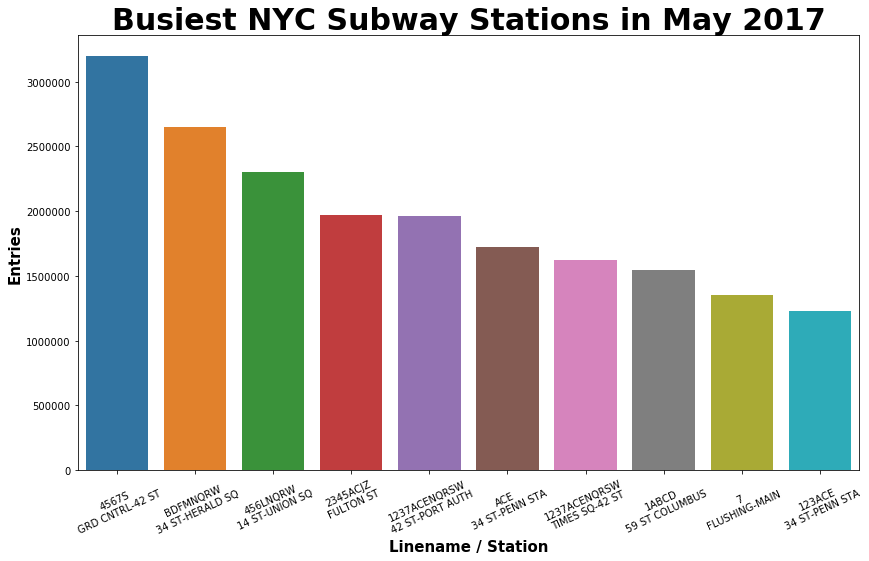

In [59]:
plt.figure(figsize=(14,8))
sb.barplot(busiest_turnstile_df['Linename'][:10] + '\n' + busiest_turnstile_df['Station'][:10], busiest_turnstile_df['Entries'][:10])
plt.title('Busiest NYC Subway Stations in May 2017',fontsize=30, weight='bold')
plt.xlabel('Linename / Station', fontsize=15, weight='bold')
plt.ylabel('Entries', fontsize=15, weight='bold')
plt.xticks(rotation=25, fontsize=10);

We wanted to see which days of the week were busiest, so we re-organized the monthly turnstile data frame into a time series graph for each top station using the top five busiest stations.

In [60]:
busy_stations = busiest_turnstile_df['Station']
timeseries_df = turnstile_df[turnstile_df['Station'].isin(busy_stations)]
timeseries_df = timeseries_df.groupby(['Linename', 'Station', 'Date'], as_index=False).sum()
timeseries_df['Date'] = pd.to_datetime(timeseries_df['Date'])
timeseries_df.head(10)

,Linename,Station,Date,Entries
0,1,103 ST,2017-04-29,2128
1,1,103 ST,2017-04-30,1871
2,1,103 ST,2017-05-01,11801
3,1,103 ST,2017-05-02,12440
4,1,103 ST,2017-05-03,12761
5,1,103 ST,2017-05-04,13059
6,1,103 ST,2017-05-05,12377
7,1,103 ST,2017-05-06,7079
8,1,103 ST,2017-05-07,5961
9,1,103 ST,2017-05-08,11965


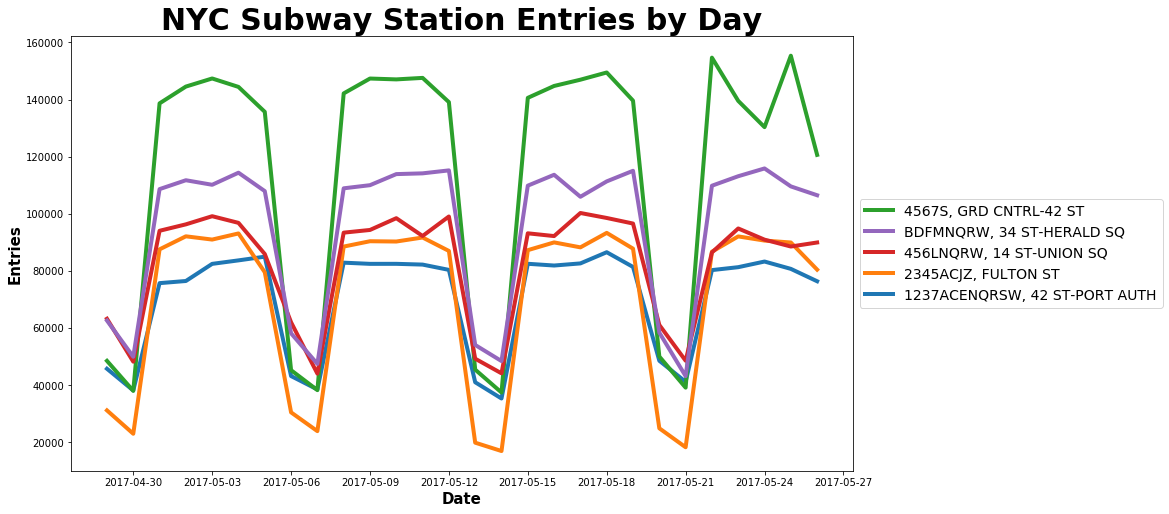

In [61]:
fig = plt.figure(1, figsize = (14, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date', fontsize=15, weight='bold')
ax1.set_ylabel('Entries', fontsize=15, weight='bold')
ax1.set_title('NYC Subway Station Entries by Day', fontsize=30, weight='bold')

busiest_five_stations = busiest_turnstile_df[:5]
for key, grp in busiest_five_stations.groupby(['Linename', 'Station']):
    station = timeseries_df[(timeseries_df['Linename'] == key[0]) & \
                             (timeseries_df['Station'] == key[1])]
    station = station.groupby('Date').sum().reset_index() 
    ax1.plot('Date', 'Entries', data = station, label = key[0] + ', ' + key[1], linewidth=4)

handles,labels = ax1.get_legend_handles_labels()
handles = [handles[2], handles[4], handles[3], handles[1], handles[0]]
labels = [labels[2], labels[4], labels[3], labels[1], labels[0]]

ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14);

While foot traffic was important in determining our station recommendations, we also wanted to target stations in neighboorhods that had more money to potentially donate. The home values in the stations' zipcodes could be a good indicator of that. We used Zillow's own house value index.

In [62]:
house_df = pd.read_csv('https://raw.githubusercontent.com/ericchan24/MTAProjectBenson/master/Zip_Zhvi_Summary_AllHomes.csv')
house_df[(house_df['State'] == 'NY')&(house_df['County'] == 'New York')].head()

,Date,RegionID,RegionName,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI
0,2017-08-31,61639,10025,NY,New York,New York,New York,0,1318000,0.02,0.11,0.18,0.11,0.06,2017-08,2017-Q3,1318000,0.00,2017-08
10,2017-08-31,61630,10016,NY,New York,New York,New York,10,1136000,0.02,0.12,0.26,0.10,0.05,2017-08,2017-Q3,1136000,0.00,2017-08
18,2017-08-31,61703,10128,NY,New York,New York,New York,18,1391400,0.02,0.08,0.31,0.12,0.05,2017-08,2017-Q3,1391400,0.00,2017-08
435,2017-08-31,61628,10014,NY,New York,New York,New York,435,1691700,0.00,0.05,0.13,0.14,nan,2017-08,2017-Q3,1691700,0.00,2017-08
1636,2017-08-31,61640,10026,NY,New York,New York,New York,1636,1091300,0.00,0.05,0.13,0.12,0.05,2017-08,2017-Q3,1091300,0.00,2017-08


In [63]:
zipcodes = [10017,11003,10003,10038,10036,10120,10036,10023,11354,10120,11220,10007,10020,10013,11372,10024,11217,10021,10011,10128,11201,10022]

In [64]:
house_df[house_df['RegionName'].isin(pd.Series(zipcodes))]

,Date,RegionID,RegionName,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI
18,2017-08-31,61703,10128,NY,New York,New York,New York,18,1391400,0.02,0.08,0.31,0.12,0.05,2017-08,2017-Q3,1391400,0.00,2017-08
39,2017-08-31,62012,11201,NY,New York,Kings,New York,39,1160000,0.02,0.08,0.25,0.13,0.09,2017-08,2017-Q3,1160000,0.00,2017-08
1729,2017-08-31,62028,11217,NY,New York,Kings,New York,1729,1209400,0.00,0.02,0.18,0.12,0.08,2017-06,2017-Q2,1210600,-0.00,2017-06
1944,2017-08-31,61627,10013,NY,New York,New York,New York,1944,3102900,-0.01,0.01,0.03,0.07,0.05,2017-07,2017-Q3,3127200,-0.01,2017-06
3278,2017-08-31,61631,10017,NY,New York,New York,New York,3278,997400,0.02,0.10,0.29,0.11,0.05,2017-08,2017-Q3,997400,0.00,2017-08
3448,2017-08-31,61652,10038,NY,New York,New York,New York,3448,1270400,0.00,0.12,0.21,0.10,0.05,2017-08,2017-Q3,1270400,0.00,2017-08
3696,2017-08-31,61978,11003,NY,New York,Nassau,Elmont,3696,414500,0.00,0.01,0.10,0.07,-0.00,2007-05,2007-Q2,435200,-0.05,2006-03
8760,2017-08-31,61621,10007,NY,New York,New York,New York,8760,2688100,-0.01,0.00,-0.00,0.07,0.04,2016-09,2016-Q3,2707000,-0.01,2016-08


Not all of the zipcodes of the busiest stations where listed. The values had to then be manually added from their website.

In [65]:
zhvi = [
    997400,
    858000,
    1737500,
    1270400,
    1549000,
    1500000,
    1549000,
    1946250,
    1080000,
    1500000,
    944000,
    2730000,
    1549000,
    3102900,
    840000,
    931000,
    1209400,
    1662500,
    1220000,
    1391400,
    1160000,
    957000
]

In [66]:
zhvi_df = pd.DataFrame(columns=[])
zhvi_df['Station'] = busiest_turnstile_df['Station']
zhvi_df['Zipcode'] = pd.Series([str(z) for z in zipcodes])
zhvi_df['Zhvi'] = pd.Series(zhvi)
zhvi_df['Entries'] = busiest_turnstile_df['Entries']
zhvi_df.head()

,Station,Zipcode,Zhvi,Entries
0,GRD CNTRL-42 ST,10017,997400.00,3197912
1,34 ST-HERALD SQ,11003,858000.00,2648443
2,14 ST-UNION SQ,10003,1737500.00,2302412
3,FULTON ST,10038,1270400.00,1966880
4,42 ST-PORT AUTH,10036,1549000.00,1963100


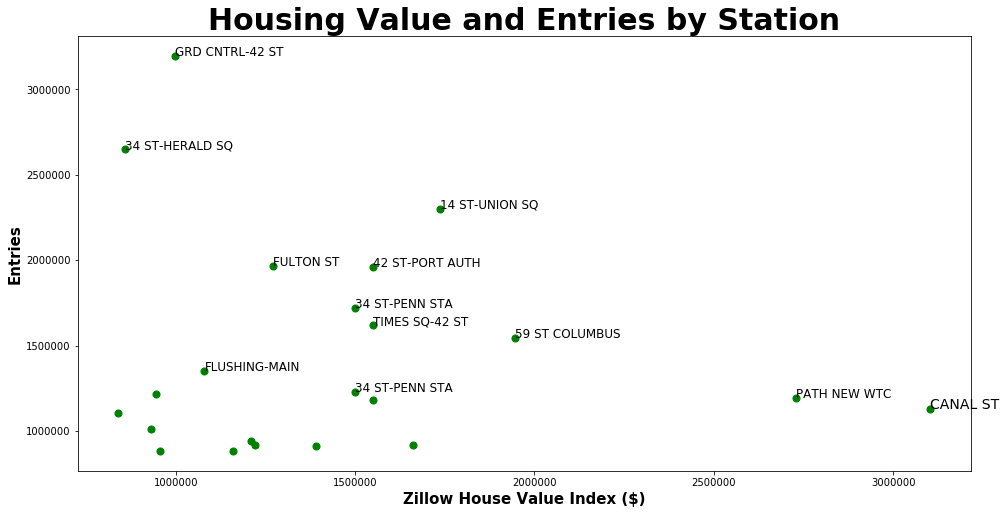

In [67]:
fig = plt.figure(1, figsize = (16, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Zillow House Value Index ($)', fontsize=15, weight='bold')
ax1.set_ylabel('Entries', fontsize=15, weight='bold')
ax1.set_title('Housing Value and Entries by Station', fontsize=30, weight='bold')
ax1.scatter(zhvi_df['Zhvi'], zhvi_df['Entries'], s= 50, marker = 'o', c='green');

for i, station in enumerate(busiest_turnstile_df['Station'][:10]):
    ax1.annotate(station, (zhvi_df['Zhvi'][i], zhvi_df['Entries'][i]), fontsize=12)

ax1.annotate('PATH NEW WTC', (zhvi_df['Zhvi'][11], zhvi_df['Entries'][11]), fontsize=12)
ax1.annotate('CANAL ST', (zhvi_df['Zhvi'][13], zhvi_df['Entries'][13]), fontsize=14);

We recommend targeting stations that both have a high amount of entries as well as being located in an area with a high housing value. Based on this criteria, we recommend the 14th Street - Union Square station, 42 Stree - Port Authority station, and Grand Central Station.